<a href="https://colab.research.google.com/github/Soubhagya0037/AutoML-Hyperparameter-optimisation/blob/main/AutoML2_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
from torchvision import datasets, transforms
import pandas as pd
import numpy as np
import random
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score


In [2]:
# Set random seeds for reproducibility
torch.manual_seed(0)
np.random.seed(0)
random.seed(0)

In [3]:
# Parameters
MAX_EVALS = 20
BATCH_SIZE = 64
EPOCHS = 5
CLASSES = 10
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
# Define a simple feedforward neural network
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)
        self.log_softmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.log_softmax(out)
        return out

In [5]:
# Train the model
def train(model, train_loader, optimizer, criterion):
    model.train()
    for data, target in train_loader:
        data, target = data.view(data.size(0), -1).to(DEVICE), target.to(DEVICE)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

In [6]:
# Evaluate the model
def evaluate(model, test_loader):
    model.eval()
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.view(data.size(0), -1).to(DEVICE), target.to(DEVICE)
            output = model(data)
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
    accuracy = correct / len(test_loader.dataset)
    return accuracy

In [7]:
# Load data
train_loader = torch.utils.data.DataLoader(
    datasets.FashionMNIST('./data', train=True, download=True, transform=transforms.ToTensor()),
    batch_size=BATCH_SIZE, shuffle=True)

test_loader = torch.utils.data.DataLoader(
    datasets.FashionMNIST('./data', train=False, transform=transforms.ToTensor()),
    batch_size=BATCH_SIZE, shuffle=False)

100%|██████████| 26421880/26421880 [00:10<00:00, 2448553.07it/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 222424.64it/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 4251375.14it/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 11703131.16it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



In [8]:
# Hyperparameter search space
param_grid = {
    'hidden_size': [64, 128, 256],
    'lr': [0.001, 0.01, 0.1],
    'batch_size': [64, 128],
    'epochs': [5, 10]
}

# Random Search Implementation

In [13]:
# Random search results storage
random_results = pd.DataFrame(columns=['params', 'accuracy', 'iteration'])

# Random Search
for i in range(MAX_EVALS):
    params = {key: random.choice(value) for key, value in param_grid.items()}
    model = NeuralNet(input_size=784, hidden_size=params['hidden_size'], num_classes=10).to(DEVICE)
    optimizer = optim.Adam(model.parameters(), lr=params['lr'])
    criterion = nn.NLLLoss()

    for epoch in range(params['epochs']):
        train(model, train_loader, optimizer, criterion)

    accuracy = evaluate(model, test_loader)
    random_results = pd.concat([random_results, pd.DataFrame({'params': [params], 'accuracy': [accuracy], 'iteration': [i]})], ignore_index=True)

# Sort and find best parameters from random search
random_results.sort_values('accuracy', ascending=False, inplace=True)
best_random_params = random_results.iloc[0]['params']
best_random_accuracy = random_results.iloc[0]['accuracy']

print(f'Best Random Search Params: {best_random_params}')
print(f'Best Random Search Accuracy: {best_random_accuracy}')


Best Random Search Params: {'hidden_size': 256, 'lr': 0.001, 'batch_size': 64, 'epochs': 10}
Best Random Search Accuracy: 0.8874


# Bayesian Optimisation

In [16]:
# Bayesian Optimization using TPE
def sample_hyperparameters(trials):
    hyperparameters = {}
    for key, values in param_grid.items():
        if trials and random.random() < 0.5:
            hyperparameters[key] = random.choice(values)
        else:
            if trials:
                best_trials = sorted(trials, key=lambda trial: trial['accuracy'], reverse=True)[:len(trials)//2]
                if best_trials:
                    hyperparameters[key] = max(best_trials, key=lambda trial: trial['accuracy'])['params'][key]
                else:
                    hyperparameters[key] = random.choice(values)
            else:
                hyperparameters[key] = random.choice(values)
    return hyperparameters

# Bayesian Optimization loop
best_accuracy = 0
best_hyperparameters = None
trials = []

for iteration in range(20):  # Perform 20 iterations for demonstration
    # Sample hyperparameters
    hyperparameters = sample_hyperparameters(trials)

    # Initialize the model
    model = NeuralNet(input_size=784, hidden_size=hyperparameters['hidden_size'], num_classes=10).to(DEVICE)

    # Load the FashionMNIST dataset
    train_loader = torch.utils.data.DataLoader(
        datasets.FashionMNIST('./data', train=True, download=True, transform=transforms.ToTensor()),
        batch_size=hyperparameters['batch_size'], shuffle=True)

    test_loader = torch.utils.data.DataLoader(
        datasets.FashionMNIST('./data', train=False, transform=transforms.ToTensor()),
        batch_size=hyperparameters['batch_size'], shuffle=False)

    # Define optimizer and loss function
    optimizer = optim.Adam(model.parameters(), lr=hyperparameters.get('lr', 0.001))  # Provide a default lr if not found
    criterion = nn.NLLLoss()

    # Train the model
    for epoch in range(hyperparameters['epochs']):
        train(model, train_loader, optimizer, criterion)

    # Evaluate the model
    accuracy = evaluate(model, test_loader)

    # Store the trial results
    trial = {'params': hyperparameters, 'accuracy': accuracy, 'iteration': iteration}
    trials.append(trial)

    # Update best hyperparameters if this model is better
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_hyperparameters = hyperparameters

    # Print progress
    print(f"Iteration {iteration+1}/20: Accuracy = {accuracy:.4f}, Best accuracy so far = {best_accuracy:.4f}")

Iteration 1/20: Accuracy = 0.7029, Best accuracy so far = 0.7029
Iteration 2/20: Accuracy = 0.5191, Best accuracy so far = 0.7029
Iteration 3/20: Accuracy = 0.4418, Best accuracy so far = 0.7029
Iteration 4/20: Accuracy = 0.7042, Best accuracy so far = 0.7042
Iteration 5/20: Accuracy = 0.8689, Best accuracy so far = 0.8689
Iteration 6/20: Accuracy = 0.8606, Best accuracy so far = 0.8689
Iteration 7/20: Accuracy = 0.8765, Best accuracy so far = 0.8765
Iteration 8/20: Accuracy = 0.8739, Best accuracy so far = 0.8765
Iteration 9/20: Accuracy = 0.8739, Best accuracy so far = 0.8765
Iteration 10/20: Accuracy = 0.8785, Best accuracy so far = 0.8785
Iteration 11/20: Accuracy = 0.6383, Best accuracy so far = 0.8785
Iteration 12/20: Accuracy = 0.6586, Best accuracy so far = 0.8785
Iteration 13/20: Accuracy = 0.8606, Best accuracy so far = 0.8785
Iteration 14/20: Accuracy = 0.8769, Best accuracy so far = 0.8785
Iteration 15/20: Accuracy = 0.8656, Best accuracy so far = 0.8785
Iteration 16/20: Ac

# Optimisation Using Hyopt Library

In [17]:
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK

In [18]:
# HyperOpt implementation
def hyperopt_objective(params):
    model = NeuralNet(input_size=784, hidden_size=int(params['hidden_size']), num_classes=10).to(DEVICE)
    optimizer = optim.Adam(model.parameters(), lr=params['lr'])
    criterion = nn.NLLLoss()

    for epoch in range(int(params['epochs'])):
        train(model, train_loader, optimizer, criterion)

    accuracy = evaluate(model, test_loader)
    return {'loss': -accuracy, 'status': STATUS_OK}

# Define the hyperparameter space
space = {
    'hidden_size': hp.choice('hidden_size', [64, 128, 256]),
    'lr': hp.loguniform('lr', -7, 0),
    'batch_size': hp.choice('batch_size', [64, 128]),
    'epochs': hp.choice('epochs', [5, 10])
}

In [19]:
# Run hyperparameter optimization with HyperOpt
hyperopt_trials = Trials()
best_hyperopt_params = fmin(hyperopt_objective, space, algo=tpe.suggest, max_evals=MAX_EVALS, trials=hyperopt_trials)
best_hyperopt_accuracy = -min(hyperopt_trials.losses())

print(f'Best HyperOpt Params: {best_hyperopt_params}')
print(f'Best HyperOpt Accuracy: {best_hyperopt_accuracy}')

100%|██████████| 20/20 [25:31<00:00, 76.58s/trial, best loss: -0.8807]
Best HyperOpt Params: {'batch_size': 1, 'epochs': 1, 'hidden_size': 1, 'lr': 0.0012383245731209152}
Best HyperOpt Accuracy: 0.8807


# Visualisation

In [28]:
# Visualization
random_params_df = pd.DataFrame([trial['params'] for trial in random_results.to_dict('records')])
random_params_df['accuracy'] = random_results['accuracy']
random_params_df['iteration'] = random_results['iteration']

bayes_params_df = pd.DataFrame([trial['params'] for trial in trials])
bayes_params_df['accuracy'] = [trial['accuracy'] for trial in trials]
bayes_params_df['iteration'] = [trial['iteration'] for trial in trials]

hyperopt_params_df = pd.DataFrame([{**{key: val[0] for key, val in trial['misc']['vals'].items() if len(val) > 0}, **{'accuracy': -trial['result']['loss'], 'iteration': i}} for i, trial in enumerate(hyperopt_trials)])
hyperopt_params_df['hidden_size'] = hyperopt_params_df['hidden_size'].map({0: 64, 1: 128, 2: 256})
hyperopt_params_df['batch_size'] = hyperopt_params_df['batch_size'].map({0: 64, 1: 128})
hyperopt_params_df['epochs'] = hyperopt_params_df['epochs'].map({0: 5, 1: 10})

plt.figure(figsize=(20, 8))
plt.rcParams['font.size'] = 18

<Figure size 2000x800 with 0 Axes>

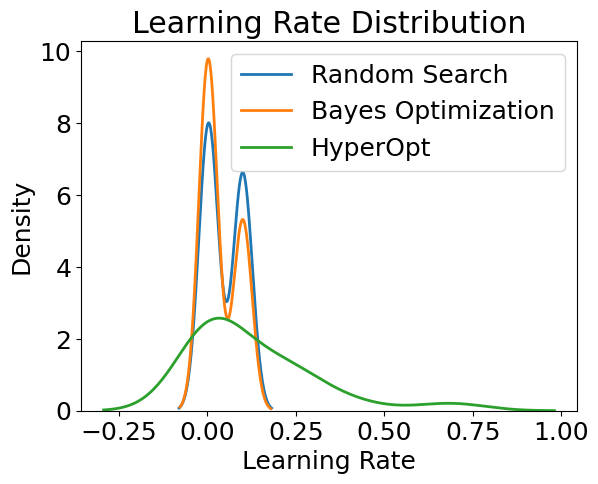

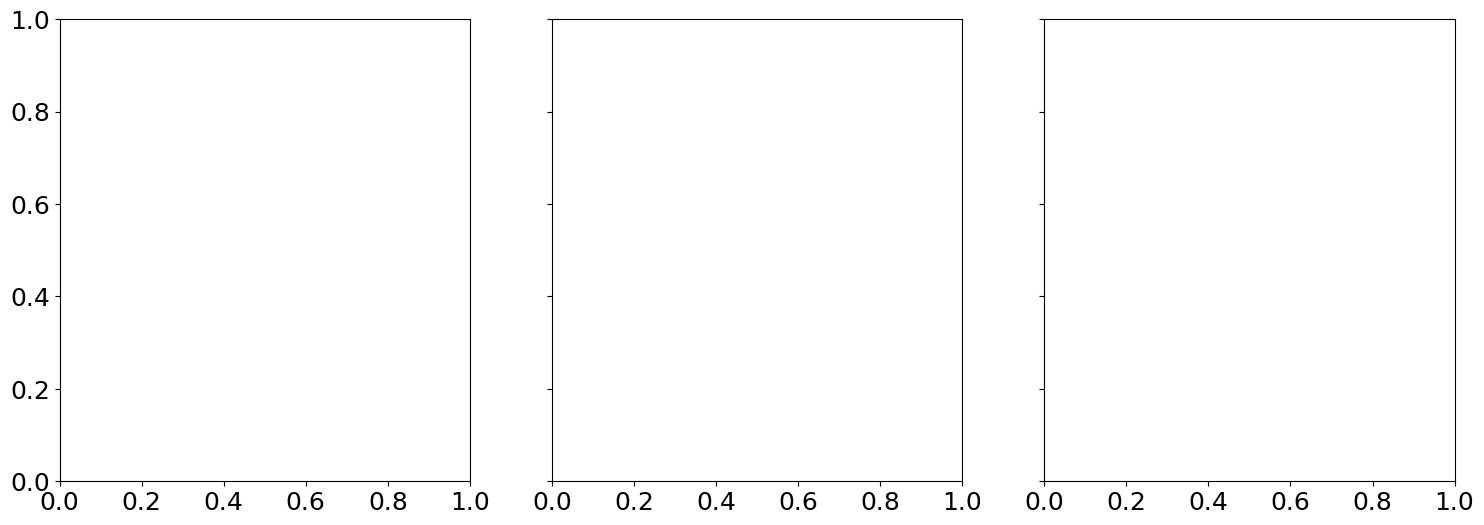

In [22]:
# Density plots of the learning rate distributions
sns.kdeplot(random_params_df['lr'], label='Random Search', linewidth=2)
sns.kdeplot(bayes_params_df['lr'], label='Bayes Optimization', linewidth=2)
sns.kdeplot(hyperopt_params_df['lr'], label='HyperOpt', linewidth=2)
plt.legend()
plt.xlabel('Learning Rate'); plt.ylabel('Density'); plt.title('Learning Rate Distribution')
plt.show()

fig, axs = plt.subplots(1, 3, sharey=True, sharex=True, figsize=(18, 6))


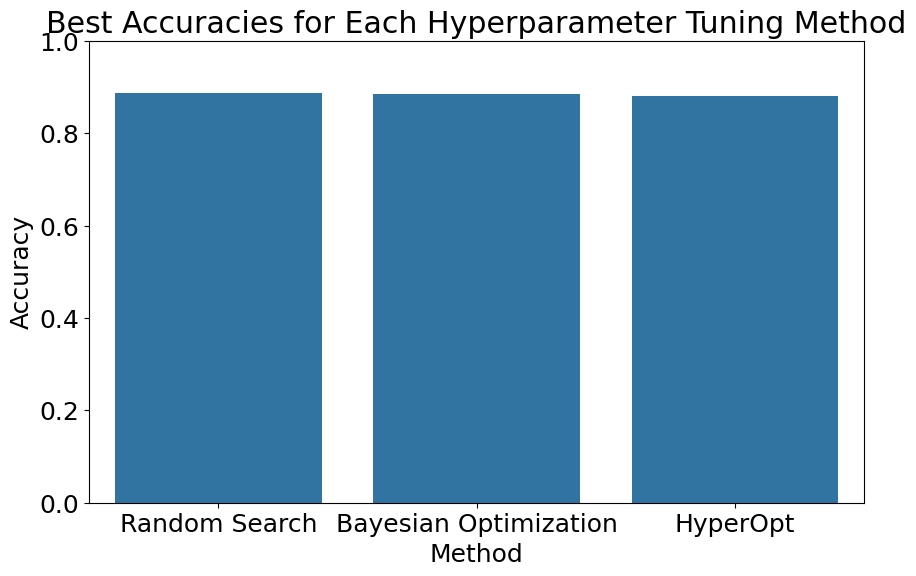

In [27]:
# Create a bar plot for the best accuracies
accuracies = [best_random_accuracy, best_accuracy, best_hyperopt_accuracy]
methods = ['Random Search', 'Bayesian Optimization', 'HyperOpt']

plt.figure(figsize=(10, 6))
sns.barplot(x=methods, y=accuracies)
plt.xlabel('Method')
plt.ylabel('Accuracy')
plt.title('Best Accuracies for Each Hyperparameter Tuning Method')
plt.ylim(0, 1)
plt.show()

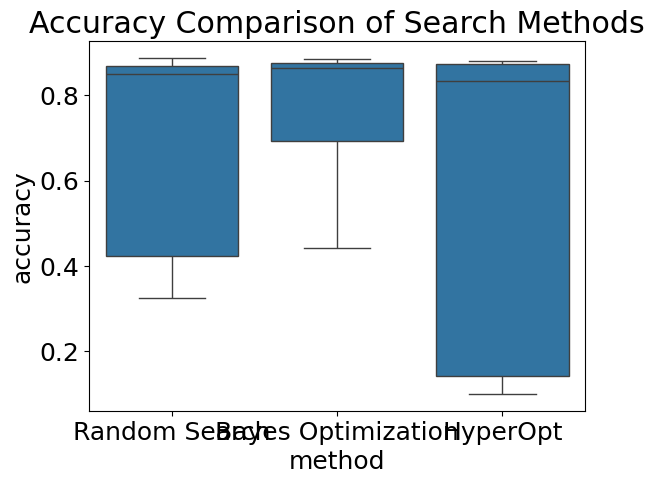

In [24]:
# Comparison of search iterations and accuracy
scores = pd.concat([pd.DataFrame({'accuracy': random_params_df['accuracy'], 'method': 'Random Search'}),
                    pd.DataFrame({'accuracy': bayes_params_df['accuracy'], 'method': 'Bayes Optimization'}),
                    pd.DataFrame({'accuracy': hyperopt_params_df['accuracy'], 'method': 'HyperOpt'})], ignore_index=True)

sns.boxplot(x='method', y='accuracy', data=scores)
plt.title('Accuracy Comparison of Search Methods')
plt.show()

<ipython-input-30-41409de393ff>:12: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(all_params_df['hidden_size'], shade=True, label='All Methods')
<ipython-input-30-41409de393ff>:16: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(all_params_df['lr'], shade=True, label='All Methods')
<ipython-input-30-41409de393ff>:20: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(all_params_df['batch_size'], shade=True, label='All Methods')
<ipython-input-30-41409de393ff>:24: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdepl

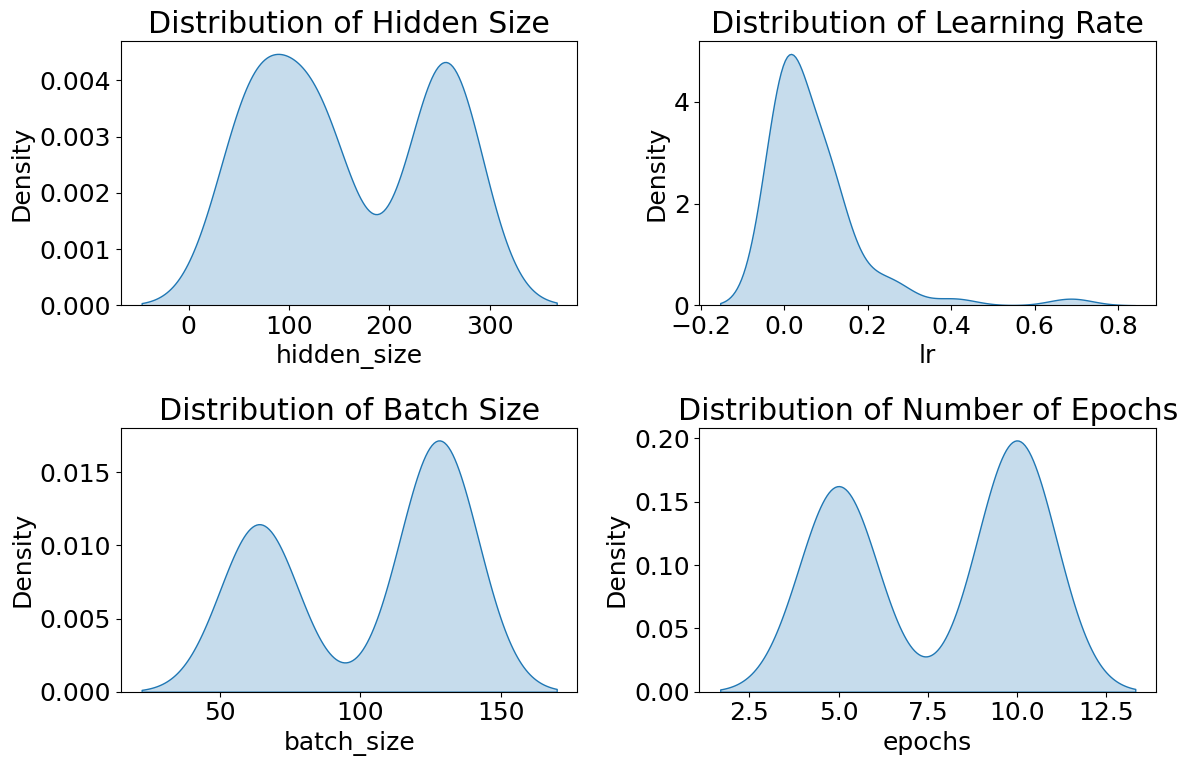

In [30]:
# Import necessary libraries
import seaborn as sns
import matplotlib.pyplot as plt

# Concatenate data from all methods into one DataFrame for plotting
all_params_df = pd.concat([random_params_df, bayes_params_df, hyperopt_params_df])

# Plot KDE distribution for each hyperparameter across methods
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
sns.kdeplot(all_params_df['hidden_size'], shade=True, label='All Methods')
plt.title('Distribution of Hidden Size')

plt.subplot(2, 2, 2)
sns.kdeplot(all_params_df['lr'], shade=True, label='All Methods')
plt.title('Distribution of Learning Rate')

plt.subplot(2, 2, 3)
sns.kdeplot(all_params_df['batch_size'], shade=True, label='All Methods')
plt.title('Distribution of Batch Size')

plt.subplot(2, 2, 4)
sns.kdeplot(all_params_df['epochs'], shade=True, label='All Methods')
plt.title('Distribution of Number of Epochs')

plt.tight_layout()
plt.show()


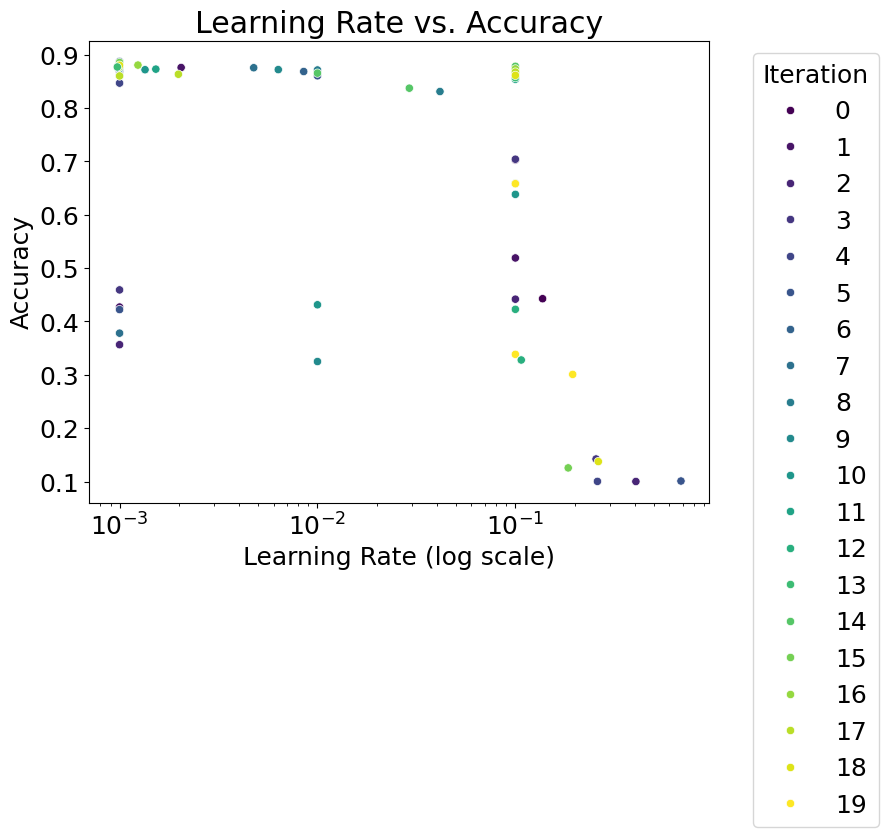

In [31]:
# Scatter plot for Learning Rate vs. Accuracy
plt.figure(figsize=(8, 6))
sns.scatterplot(x='lr', y='accuracy', hue='iteration', data=all_params_df, palette='viridis', legend='full')
plt.xscale('log')  # Log scale for learning rate
plt.xlabel('Learning Rate (log scale)')
plt.ylabel('Accuracy')
plt.title('Learning Rate vs. Accuracy')
plt.legend(title='Iteration', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()
